In [6]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Load the training data**

Here we load the training data without cleaning it

In [61]:
import datetime
from implementations import *

data, pred, ids = load_data("train.csv")
for i in range(data.shape[1]):
    data[:, i] = standardize(data[:, i])[0]
y, tx = build_model_data(data, pred)

## Linear regression using gradient descent

Here we train our model using GD with MSE

In [90]:
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 0.16

start_time = datetime.datetime.now()
w, loss = mean_squared_error_gd(y, tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 1.260239 seconds


### Compute the accuracy

In [91]:
actual_pred = np.dot(tx, w)
actual_pred = (actual_pred > 0.5).astype(float)
correctly_classified = np.sum(actual_pred == pred)
accuracy = correctly_classified / len(pred)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 74.344%


### Feature analysis

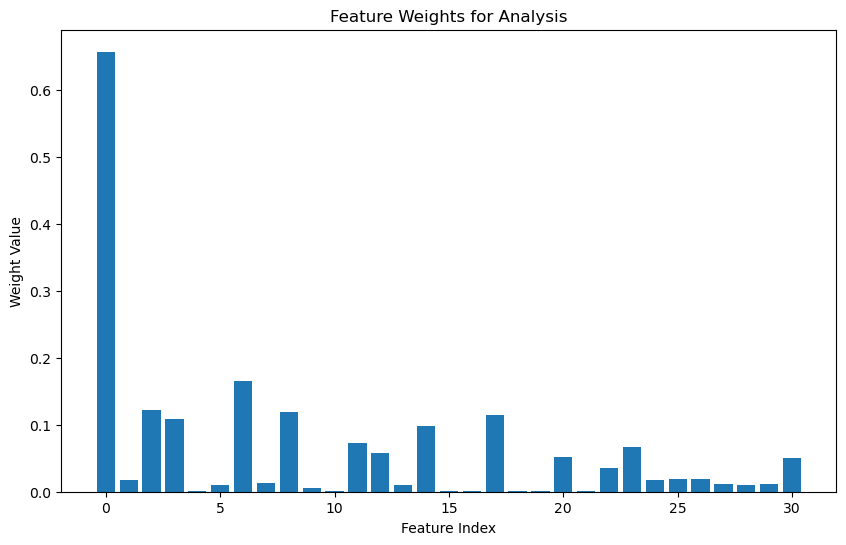

In [66]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(w)), np.abs(w))
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

**We select only the most influent features and train back our parameters to see if we get better accuracy**

In [67]:
filter_data = tx[:, w > 0.0000005]
y, tx_filtered = build_model_data(filter_data, pred)
print(tx_filtered.shape)

(250000, 20)


In [68]:
initial_w = np.zeros(tx_filtered.shape[1])
max_iters = 100
gamma = 0.17

start_time = datetime.datetime.now()
w_filtered, loss_filtered = mean_squared_error_gd(y, tx_filtered, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds with loss = {loss_filtered}")

Execution time 0.604455 seconds with loss = 0.0941080308124632


In [69]:
actual_pred = np.dot(tx_filtered, w_filtered)
actual_pred = (actual_pred > 0.5).astype(float)
correctly_classified = np.sum(actual_pred == pred)
accuracy = correctly_classified / len(pred)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 71.4924%


### Results

We see that the accuracy is less precise but the complexity is better by a factor of 10

# **Load and clean the training data**

Here we also clean the data

In [70]:
data_clean, pred_clean, ids_clean = load_data("train.csv")
for i in range(data_clean.shape[1]):
    data_clean[:, i] = standardize_clean(data_clean[:, i])
y_clean, tx_clean = build_model_data(data_clean, pred_clean)

### Linear regression using gradient descent

Here we train our model using GD with MSE

In [112]:
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 0.332

start_time = datetime.datetime.now()
w_clean, loss_clean = mean_squared_error_gd(y_clean, tx_clean, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 1.282886 seconds


### Compute the accuracy

In [113]:
actual_pred = np.dot(tx_clean, w_clean)
actual_pred = (actual_pred > 0.5).astype(float)
correctly_classified = np.sum(actual_pred == pred_clean)
accuracy = correctly_classified / len(pred_clean)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 74.516%


### Feature analysis

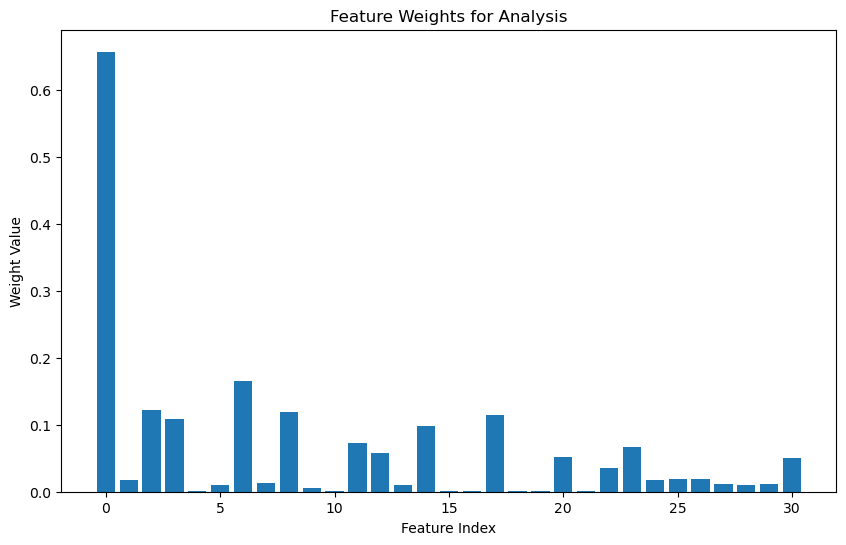

In [73]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(w)), np.abs(w))
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

### Results

We can conclude that cleaning the data by remplacing the outliers by the mean value doesn't really change that much

# **Load the testing data**

In [ ]:
test_data, test_pred, test_ids = load_data("test.csv")
for i in range(test_data.shape[1]):
    test_data[:][i] = standardize(test_data[:][i])[0]
test_y, test_tx = build_model_data(test_data, test_pred)

### Predict the label with our trained model

In [112]:
test_y = np.dot(test_tx, w)
test_y = (test_y > 0.5).astype(float)